<a href="https://colab.research.google.com/github/agustinparada/Fisica_Computacional_I/blob/master/Actividad_12/Actividad12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Actividad 12***

José Agustín Parada Peralta. 

Departamento de Física. 

Universidad de Sonora.

In [ ]:
from scipy import sparse
import numpy as np
from scipy.sparse.linalg import spsolve
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

Se utiliza el método de diferencias finitas para resolver la ecuación de Poisson en distintos casos. Se utiliza una ecuación general matricial de la forma:

$$ AU=F $$
Donde $U$ es una matriz de puntos internos definida como:
$$ U = \begin{bmatrix} U_1\\ U_2 \\ U_3 \end{bmatrix} $$
Donde:
$$ U_1 = \begin{bmatrix} U_{1,1} \\ U_{2,1} \\ U_{3,1} \end{bmatrix};\; U_2 = \begin{bmatrix} U_{1,2} \\ U_{2,2} \\ U_{3,2} \end{bmatrix};\; U_3 = \begin{bmatrix} U_{1,3} \\ U_{2,3} \\ U_{3,3} \end{bmatrix} $$
Además, la matriz $A$ viene dada por:
$$ A =\frac{1}{h^2} \begin{bmatrix} B & -I \\ -I & B & -I \\  & -I & B & -I \\ & \dots & \dots & \dots \\ & & -I & B \end{bmatrix} $$

Donde $I$ es la matriz identidad de $(M-2)\times (M-2)$ y $B$ una matriz $(M-2)\times (M-2)$ definida como:
$$ B = \begin{bmatrix} 4 & -1 & 0 & 0 & \dots & 0 \\ -1 & 4 & -1 & 0 & \dots & 0 \\ 0 & -1 & 4 & -1 & \dots & 0 \\ & & & & \vdots & \\ 0 & 0 & 0 & \dots & -1 & 4\ \end{bmatrix} $$

Además, la Matriz $F$ de la derecha de la ecuación presentada al principio viene dada por:

$$ F = \begin{bmatrix} f_1 + \frac{g_0+g_1}{h^2} \\ f_2 + \frac{g_2}{h^2} \\ \vdots \\ f_{M-2} + \frac{g_{M-2}}{h^2} \\ f_{M-1} + \frac{g_{M-1}+g_M}{h^2} \end{bmatrix} $$

# ***Ejercicio 1***

Se resolverá la ecuación de Poisson como sigue:

$$ -\nabla^2u = \cos{(2\pi x)}\sin{(3\pi y)} $$

Teniendo en cuenta las siguientes condiciones de frontera de Dirichlet:

\begin{align*}
u(0,y) &= 0\\
u(1,y) &= 0\\
u(x,0) &= 0\\
u(x,1) &= 0
\end{align*}

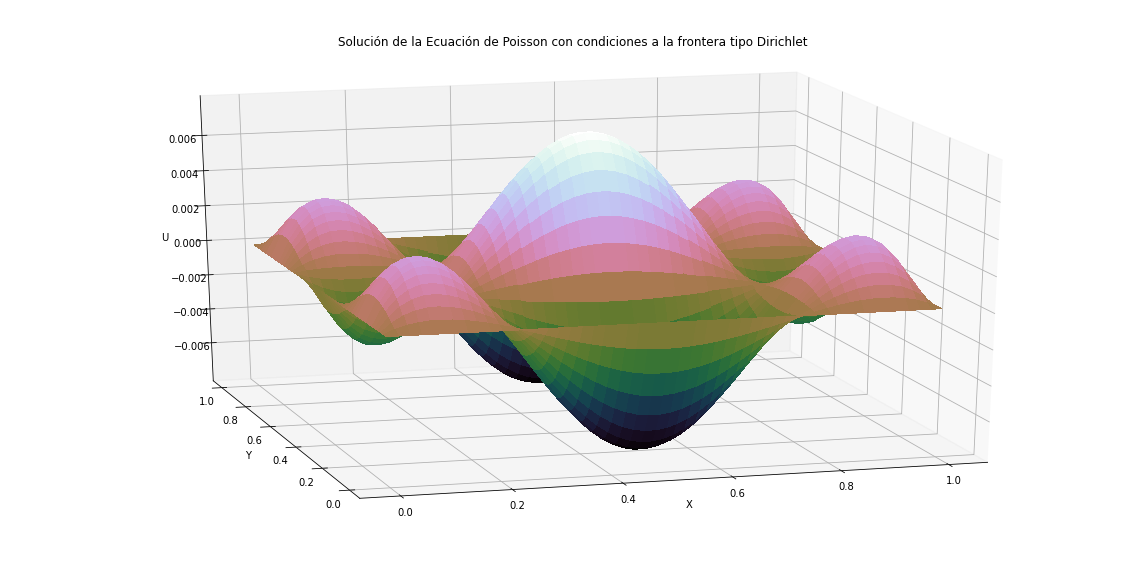

In [ ]:
def rhs_func(x, y, M):
    ###----- Element-wise multiplication -----###
    g = (np.multiply(np.cos(2*np.pi*X[1:-1,1:-1]), np.sin(3*np.pi*Y[1:-1,1:-1]))).flatten()
    f = [g[i::M-2] for i in range(M-2)] # Extracts only the inner values
    f = np.asarray(f).flatten() # Flattens into a ((M-2)**2, ) array
    return f


def bc_dirichlet(x, y, m):
    ###----- Initializes boundary condition values -----###
    lBC = 0*Y[:,0]
    leftBC = lBC[1:M-1]
    
    rBC = np.zeros((M,1)).flatten()
    rightBC = rBC[1:M-1]
    
    tBC = 0*X[0,:]
    topBC = tBC[1:M-1]
    
    bBC = np.zeros((1,M)).flatten()
    bottomBC = bBC[1:M-1]
    
    ###----- Creates a ((M-2)**2, ) array of zeros -----###
    g1 = np.zeros(((M-2)**2, 1)).flatten()
    
    ###----- Fills in the top BC (red circles on p. 21) -----###
    for i in range(M-2):
        g1[(M-2)*i] = topBC[i] 
    
    ###----- Fills in the bottom BC (blue circles on p. 21) -----###
    for j in range(M-2):
        g1[(M-2)*(j+1)-1] = bottomBC[j]
    
    ###----- Fills in the left BC (top orange circle on p. 21) -----###
    k1 = np.zeros((len(leftBC),1))
    k1[0] = 1.0
    leftBCk = sparse.kron(k1,leftBC).toarray().flatten()
    
    ###----- Fills in the right BC (bottom orange circle on p. 21) -----###
    k2 = np.zeros((len(rightBC),1))
    k2[-1] = 1.0
    rightBCk = sparse.kron(k2,rightBC).toarray().flatten()
    
    ###----- Collects all -----###
    g = g1 + leftBCk + rightBCk
    
    return [g, lBC, tBC, rBC, bBC]
    

def generate_lhs_matrix(M, hx, hy):
    
    alpha = hx**2/hy**2

    main_diag = 2 * (1 + alpha) * np.ones((M - 2, 1)).ravel()
    off_diag = -1 * np.ones((M - 2, 1)).ravel()
    
    a = main_diag.shape[0]

    diagonals = [main_diag, off_diag, off_diag]

    B = sparse.diags(diagonals, [0, -1, 1], shape=(a, a)).toarray()
    
    C = sparse.diags([-1*np.ones((M+1, 1)).ravel()], [0], shape=(a,a)).toarray()
        
    e1 = sparse.eye(M-2).toarray()
    
    A1 = sparse.kron(e1,B).toarray()
    
    e2 = sparse.diags([1*np.ones((M, 1)).ravel(),1*np.ones((M, 1)).ravel()], [-1,1], shape=(M-2,M-2)).toarray()
    
    A2 = sparse.kron(e2,C).toarray()
    
    mat = A1 + A2

    return mat


###========================================###

M = 50
(x0, xf) = (0.0, 1.0)
(y0, yf) = (0.0, 1.0)

hx = (xf - x0)/(M-1)
hy = (yf - y0)/(M-1)

x1 = np.linspace(x0, xf, M)
y1 = np.linspace(y0, yf, M)

###----- Generates a grid ----###
X, Y = np.meshgrid(x1, y1)

###----- The right hand side function ----###
frhs = rhs_func(X, Y, M)

###----- Boundary conditions ----###
fbc = bc_dirichlet(X, Y, M)

rhs = frhs*(hx**2) + fbc[0]

A = generate_lhs_matrix(M, hx, hy)

###----- Solves A*x=b --> x=A\b ----###
V = np.linalg.solve(A,rhs)

###----- Reshapes the 1D array into a 2D array -----###
V = V.reshape((M-2, M-2)).T

###----- Fills in boundary values for Dirichlet BC -----###
U = np.zeros((M,M))

U[1:M-1, 1:M-1] = V
U[:,0] = fbc[1]
U[0,:] = fbc[2]
U[:,M-1] = fbc[3]
U[M-1,:] = fbc[4]

###----- Plots -----###
fig = plt.figure(figsize=(16,8))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, U, cmap=cm.cubehelix,
                       linewidth=0, antialiased=False)

###----- Static image -----###
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('U')
ax.set_title("Solución de la Ecuación de Poisson con condiciones a la frontera tipo Dirichlet")
plt.tight_layout()
ax.view_init(20, -106)
plt.show()

# ***Ejercicio 2***

Resolveremos la ecuación de Poisson dada como sigue:

$$ -\nabla^2u = \sin{(n\pi x)}\sin{(m\pi y)} $$

Para los casos:
\begin{align*}
n=1 &;\: m= 1\\
n=1 & ;\: m = 3 \\
n=2 & ;\: m=2
\end{align*}

Considerando las condiciones a la frontera de tipo Dirichlet:

\begin{align*}
u(0,y) &= 0\\
u(1,y) &= 0\\
u(x,0) &= 0\\
u(x,1) &= 0
\end{align*}

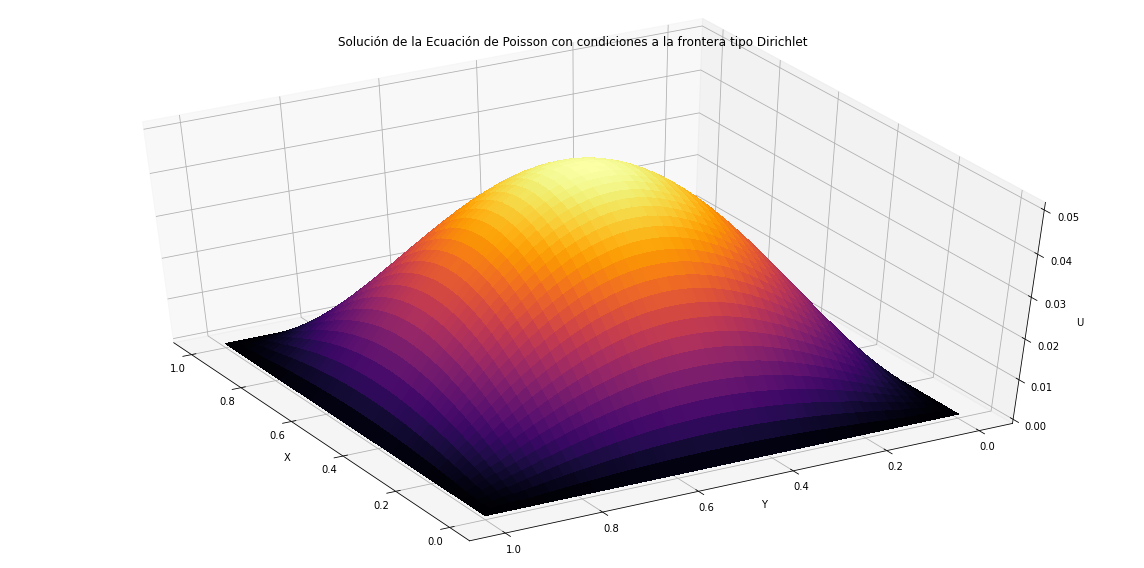

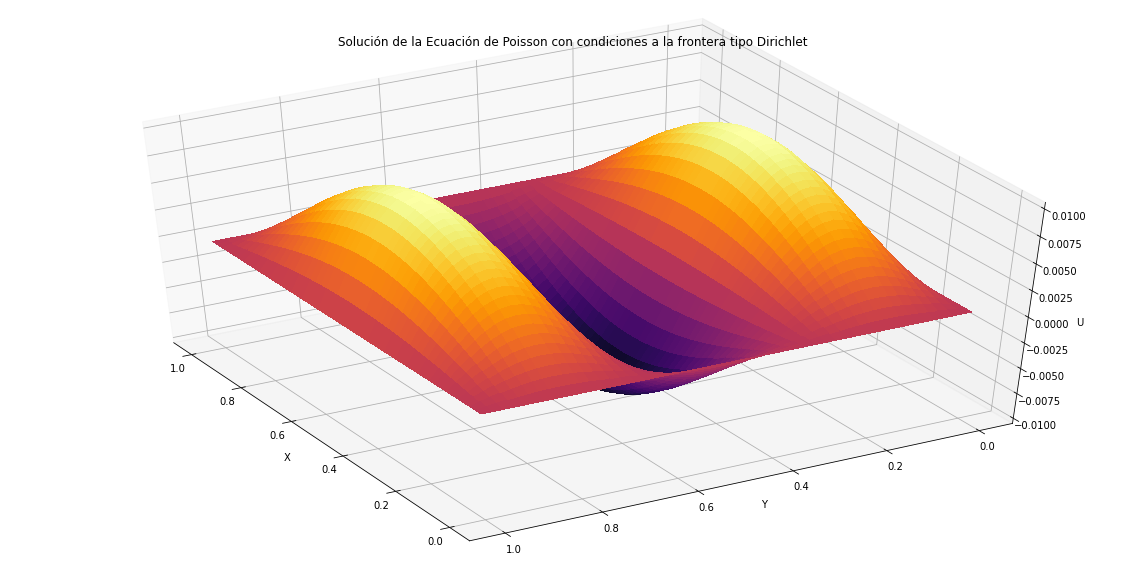

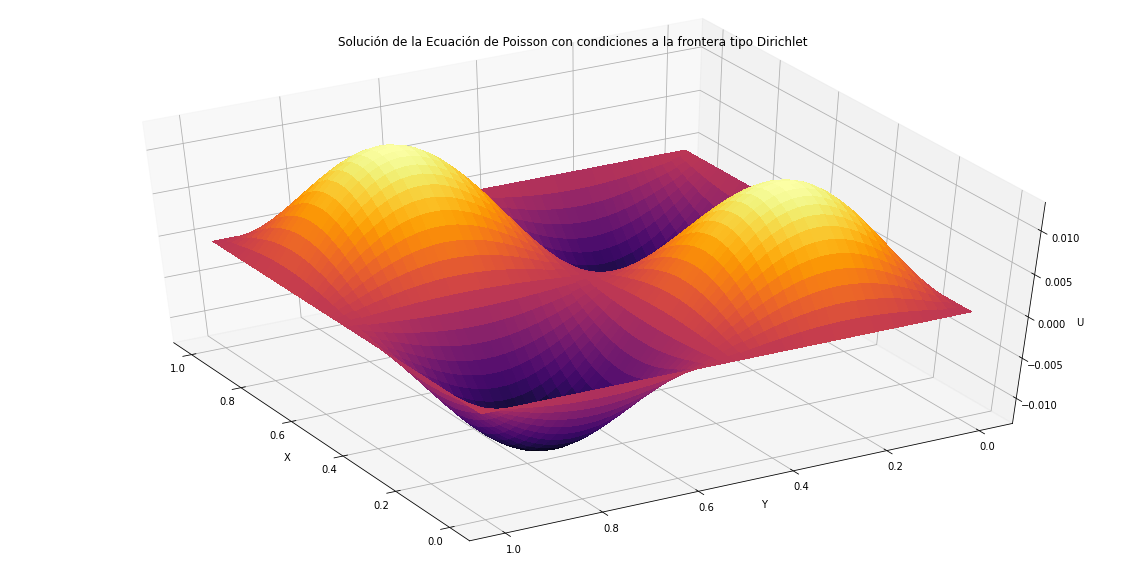

In [ ]:
def rhs_func(x, y, M, n, m):
    ###----- Element-wise multiplication -----###
    g = (np.multiply(np.sin(n*np.pi*X[1:-1,1:-1]), np.sin(m*np.pi*Y[1:-1,1:-1]))).flatten()
    f = [g[i::M-2] for i in range(M-2)] # Extracts only the inner values
    f = np.asarray(f).flatten() # Flattens into a ((M-2)**2, ) array
    return f


def bc_dirichlet(x, y, m):
    ###----- Initializes boundary condition values -----###
    lBC = 0*Y[:,0]
    leftBC = lBC[1:M-1]
    
    rBC = np.zeros((M,1)).flatten()
    rightBC = rBC[1:M-1]
    
    tBC = 0*X[0,:]
    topBC = tBC[1:M-1]
    
    bBC = np.zeros((1,M)).flatten()
    bottomBC = bBC[1:M-1]
    
    ###----- Creates a ((M-2)**2, ) array of zeros -----###
    g1 = np.zeros(((M-2)**2, 1)).flatten()
    
    ###----- Fills in the top BC (red circles on p. 21) -----###
    for i in range(M-2):
        g1[(M-2)*i] = topBC[i] 
    
    ###----- Fills in the bottom BC (blue circles on p. 21) -----###
    for j in range(M-2):
        g1[(M-2)*(j+1)-1] = bottomBC[j]
    
    ###----- Fills in the left BC (top orange circle on p. 21) -----###
    k1 = np.zeros((len(leftBC),1))
    k1[0] = 1.0
    leftBCk = sparse.kron(k1,leftBC).toarray().flatten()
    
    ###----- Fills in the right BC (bottom orange circle on p. 21) -----###
    k2 = np.zeros((len(rightBC),1))
    k2[-1] = 1.0
    rightBCk = sparse.kron(k2,rightBC).toarray().flatten()
    
    ###----- Collects all -----###
    g = g1 + leftBCk + rightBCk
    
    return [g, lBC, tBC, rBC, bBC]
    

def generate_lhs_matrix(M, hx, hy):
    
    alpha = hx**2/hy**2

    main_diag = 2 * (1 + alpha) * np.ones((M - 2, 1)).ravel()
    off_diag = -1 * np.ones((M - 2, 1)).ravel()
    
    a = main_diag.shape[0]

    diagonals = [main_diag, off_diag, off_diag]

    B = sparse.diags(diagonals, [0, -1, 1], shape=(a, a)).toarray()
    
    C = sparse.diags([-1*np.ones((M+1, 1)).ravel()], [0], shape=(a,a)).toarray()
        
    e1 = sparse.eye(M-2).toarray()
    
    A1 = sparse.kron(e1,B).toarray()
    
    e2 = sparse.diags([1*np.ones((M, 1)).ravel(),1*np.ones((M, 1)).ravel()], [-1,1], shape=(M-2,M-2)).toarray()
    
    A2 = sparse.kron(e2,C).toarray()
    
    mat = A1 + A2

    return mat


###========================================###

M = 50
(x0, xf) = (0.0, 1.0)
(y0, yf) = (0.0, 1.0)

hx = (xf - x0)/(M-1)
hy = (yf - y0)/(M-1)

x1 = np.linspace(x0, xf, M)
y1 = np.linspace(y0, yf, M)

###----- Generates a grid ----###
X, Y = np.meshgrid(x1, y1)

###----- The right hand side function ----###
Nsin=[1,1,2]
Msin=[1,3,2]
for n, m in zip(Nsin,Msin):
  frhs = rhs_func(X, Y, M, n, m)

###----- Boundary conditions ----###
  fbc = bc_dirichlet(X, Y, M)

  rhs = frhs*(hx**2) + fbc[0]

  A = generate_lhs_matrix(M, hx, hy)

###----- Solves A*x=b --> x=A\b ----###
  V = np.linalg.solve(A,rhs)

###----- Reshapes the 1D array into a 2D array -----###
  V = V.reshape((M-2, M-2)).T

###----- Fills in boundary values for Dirichlet BC -----###
  U = np.zeros((M,M))

  U[1:M-1, 1:M-1] = V
  U[:,0] = fbc[1]
  U[0,:] = fbc[2]
  U[:,M-1] = fbc[3]
  U[M-1,:] = fbc[4]

###----- Plots -----###
  fig = plt.figure(figsize=(16,8))
  ax = fig.gca(projection='3d')

  surf = ax.plot_surface(X, Y, U, cmap=cm.inferno,
                       linewidth=0, antialiased=False)

###----- Static image -----###
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('U')
  ax.set_title("Solución de la Ecuación de Poisson con condiciones a la frontera tipo Dirichlet")
  plt.tight_layout()
  ax.view_init(45, 150)
  plt.show()

# ***Ejercicio 3***

Se resolverá la ecuación de Poisson dada como sigue:

$$ -\nabla^2u = -\pi \cos{(\pi x)}-\pi \cos{(\pi y)} $$

Utilizando las condiciones a la frontera de tipo Neumann:

\begin{align*}
\frac{\partial u}{\partial x}(0,y) &= 0 \\
\frac{\partial u}{\partial x}(1,y) &= 0 \\
\frac{\partial u}{\partial y}(x,0) &= 0 \\
\frac{\partial u}{\partial y}(x,1) &= 0
\end{align*}

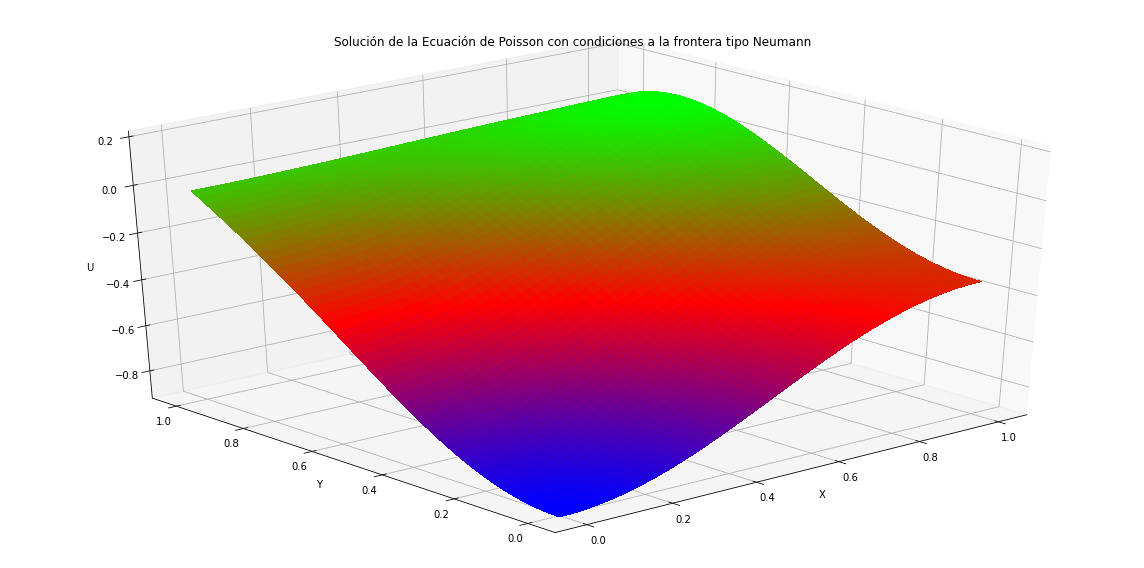

In [ ]:
def rhs_func(X, Y, M):
    ###----- Right hand side, element-wise multiplication -----###
    g = (-np.pi*np.cos(np.pi*X)-np.pi*np.cos(np.pi*Y)).flatten()
    f = [g[i::M] for i in range(M)]
    f = np.asarray(f).flatten()
    return f
    
  
def generate_lhs_matrix(M, hx, hy):
    alpha = hx**2/hy**2
    
    main_diag = 2*(1+alpha)*np.ones((M, 1)).ravel()
    off_diag = -1*np.ones((M-1, 1)).ravel()
    
    a = main_diag.shape[0]
    
    diagonals = [main_diag, off_diag, off_diag]
    
    B = sparse.diags(diagonals, [0,-1,1], shape=(a,a)).toarray()
    B[0,1] = -2.0
    #B[M-1,M-2] = -2.0
    
    D = sparse.diags([-1*np.ones((M+1, 1)).ravel()], [0], shape=(a,a)).toarray()
    
    C = sparse.diags([-2*np.ones((M+1, 1)).ravel()], [0], shape=(a,a)).toarray()
    
    e1 = sparse.eye(M).toarray()
    A1 = sparse.kron(e1,B).toarray()
    
    e2 = sparse.diags([1*np.ones((M, 1)).ravel(),1*np.ones((M, 1)).ravel()], [-1,1], shape=(M,M)).toarray()
    e2[0,1] = 0.0
    e2[M-1,M-2] = 0.0
    A2 = sparse.kron(e2,D).toarray()
    
    e3 = sparse.diags([1*np.ones((M, 1)).ravel(),1*np.ones((M, 1)).ravel()], [-1,1], shape=(M,M)).toarray()
    e3[1:M-1,0:M] = 0.0
    A3 = sparse.kron(e3,C).toarray()
    
    mat = A1 + A2 + A3
    
    return mat
    
#########################################

    
M = 50
(x0, xf) = (0.0, 1.0)
(y0, yf) = (0.0, 1.0)

hx = (xf - x0)/(M-1)
hy = (yf - y0)/(M-1)

X, Y = np.meshgrid(np.linspace(x0, xf, M), np.linspace(y0, yf, M))

f = rhs_func(X, Y, M)

A = generate_lhs_matrix(M, hx, hy)

U = np.linalg.solve(A,f*(hx**2)) # Solve x=A\b

U = U.reshape((M,M)).T

## The zero-flux boundary conditions are incorporated in
## matrix A.


fig = plt.figure(figsize=(16,8))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, U, cmap=cm.brg,
                       linewidth=0, antialiased=False)


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('U')
ax.set_zlim3d(-0.9,0.2)
ax.set_title("Solución de la Ecuación de Poisson con condiciones a la frontera tipo Neumann")
plt.tight_layout()
ax.view_init(31, -131)
plt.show()

# ***Ejercicio 4***

Se resolverá la ecuación de Poisson dada por:

$$ -\nabla^2u = -2\pi^2 \sin{(\pi (x+y))} $$

Con condiciones en la frontera de tipo Neumann dadas por:

\begin{align*}
\frac{\partial u}{\partial x}(0,y) &= 0 \\
\frac{\partial u}{\partial x}(1,y) &= 0 \\
\frac{\partial u}{\partial y}(x,0) &= 0 \\
\frac{\partial u}{\partial y}(x,1) &= 0
\end{align*}

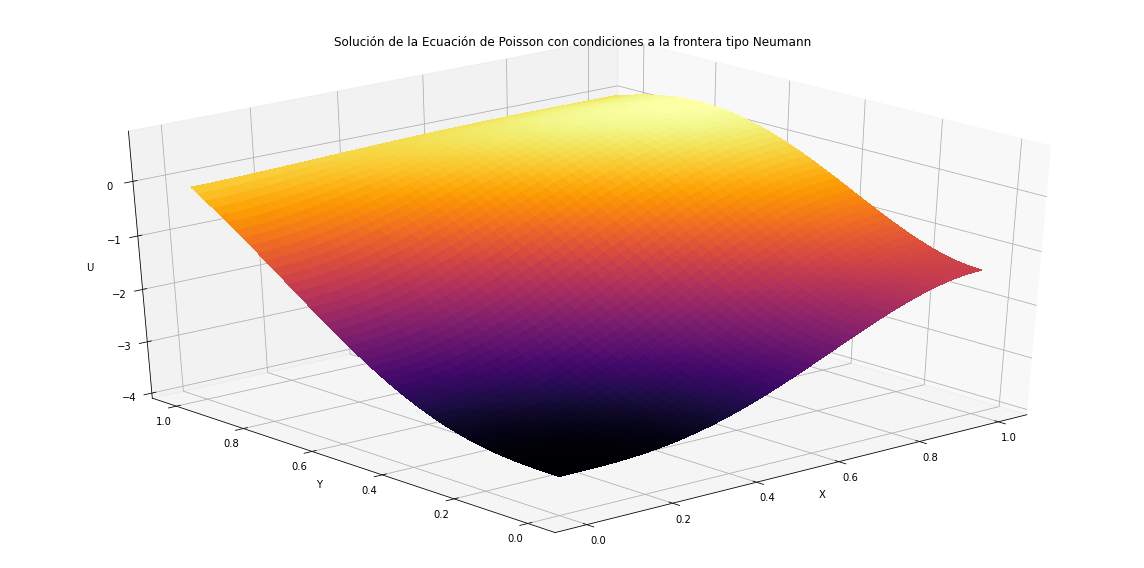

In [ ]:
def rhs_func(X, Y, M):
    ###----- Right hand side, element-wise multiplication -----###
    g = (-2*np.pi**2*np.sin(np.pi*(X+Y))).flatten()
    f = [g[i::M] for i in range(M)]
    f = np.asarray(f).flatten()
    return f
    
  
def generate_lhs_matrix(M, hx, hy):
    alpha = hx**2/hy**2
    
    main_diag = 2*(1+alpha)*np.ones((M, 1)).ravel()
    off_diag = -1*np.ones((M-1, 1)).ravel()
    
    a = main_diag.shape[0]
    
    diagonals = [main_diag, off_diag, off_diag]
    
    B = sparse.diags(diagonals, [0,-1,1], shape=(a,a)).toarray()
    B[0,1] = -2.0
    #B[M-1,M-2] = -2.0
    
    D = sparse.diags([-1*np.ones((M+1, 1)).ravel()], [0], shape=(a,a)).toarray()
    
    C = sparse.diags([-2*np.ones((M+1, 1)).ravel()], [0], shape=(a,a)).toarray()
    
    e1 = sparse.eye(M).toarray()
    A1 = sparse.kron(e1,B).toarray()
    
    e2 = sparse.diags([1*np.ones((M, 1)).ravel(),1*np.ones((M, 1)).ravel()], [-1,1], shape=(M,M)).toarray()
    e2[0,1] = 0.0
    e2[M-1,M-2] = 0.0
    A2 = sparse.kron(e2,D).toarray()
    
    e3 = sparse.diags([1*np.ones((M, 1)).ravel(),1*np.ones((M, 1)).ravel()], [-1,1], shape=(M,M)).toarray()
    e3[1:M-1,0:M] = 0.0
    A3 = sparse.kron(e3,C).toarray()
    
    mat = A1 + A2 + A3
    
    return mat
    
#########################################

    
M = 50
(x0, xf) = (0.0, 1.0)
(y0, yf) = (0.0, 1.0)

hx = (xf - x0)/(M-1)
hy = (yf - y0)/(M-1)

X, Y = np.meshgrid(np.linspace(x0, xf, M), np.linspace(y0, yf, M))

f = rhs_func(X, Y, M)

A = generate_lhs_matrix(M, hx, hy)

U = np.linalg.solve(A,f*(hx**2)) # Solve x=A\b

U = U.reshape((M,M)).T

## The zero-flux boundary conditions are incorporated in
## matrix A.


fig = plt.figure(figsize=(16,8))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, U, cmap=cm.inferno,
                       linewidth=0, antialiased=False)


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('U')
ax.set_zlim3d(-4.0,0.8)
ax.set_title("Solución de la Ecuación de Poisson con condiciones a la frontera tipo Neumann")
plt.tight_layout()
ax.view_init(31, -131)
plt.show()